In [379]:
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels
from collections import Counter
import cpi
import ast
import json
import datetime
from sklearn.decomposition import PCA
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from sklearn import preprocessing
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [54]:
# Datasets loading
dataset_original = pd.read_csv('./tmdb-box-office-prediction/train.csv')
dataset = dataset_original

oscars = pd.read_csv('./tmdb-box-office-prediction/the_oscar_award.csv')
oscars_winners = oscars[oscars["winner"] == True].drop(columns=["winner", "year_film", "year_ceremony", "ceremony", "category", "name"])
oscars_winners = oscars_winners[oscars_winners["film"].notnull()]
dataset_lc = dataset.copy()
oscars_winners_lc = oscars_winners.copy()
dataset_lc['title'] = dataset_lc['title'].str.lower()
oscars_winners_lc['film'] = oscars_winners_lc['film'].str.lower()
oscar_movies = pd.merge(left=dataset_lc, right=oscars_winners_lc, left_on='title', right_on='film').drop_duplicates(subset='id')
oscar_movies = oscar_movies.drop(columns=['film'])

dataset = text_to_dict(dataset)
dataset["release_date"] = dataset["release_date"].apply(fix_date)
dataset["budget"] = dataset.apply(lambda x: adjust_price_to_inflation(x["budget"], x["release_date"]), axis=1)
dataset["revenue"] = dataset.apply(lambda x: adjust_price_to_inflation(x["revenue"], x["release_date"]), axis=1)

oscar_movies = text_to_dict(oscar_movies)
oscar_movies["release_date"] = oscar_movies["release_date"].apply(fix_date)
oscar_movies["budget"] = oscar_movies.apply(lambda x: adjust_price_to_inflation(x["budget"], x["release_date"]), axis=1)
oscar_movies["revenue"] = oscar_movies.apply(lambda x: adjust_price_to_inflation(x["revenue"], x["release_date"]), axis=1)

In [55]:
print(dataset.info())
print(dataset.describe(include=[np.number]))
dataset.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     3000 non-null   int64         
 1   belongs_to_collection  3000 non-null   object        
 2   budget                 3000 non-null   int64         
 3   genres                 3000 non-null   object        
 4   homepage               946 non-null    object        
 5   imdb_id                3000 non-null   object        
 6   original_language      3000 non-null   object        
 7   original_title         3000 non-null   object        
 8   overview               2992 non-null   object        
 9   popularity             3000 non-null   float64       
 10  poster_path            2999 non-null   object        
 11  production_companies   3000 non-null   object        
 12  production_countries   3000 non-null   object        
 13  rel

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  15101018   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  54135944   
2   3                                                 {}   3563750   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                      [{'id': 18, 'name': 'Drama'}]   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  tt0368933                en   
2  http://sonyclassics.com/whiplash/  tt2582802                en   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   

                                            overview  popularity  ...  \
0  When Lou, who has become the "father of the In...    6.575393  ...   
1  Mia Thermopolis is now a college graduate and ...    8.248895  ...   
2  Under the direction of a ruthless instructor, ...   64.299990  ...   

  release_date runtime                          spoken_languages    status  \
0   2015-02-20    93.0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   
1   2004-08-06   113.0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2   2014-10-10   105.0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   
2  [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   
2  [{'cast_id': 5, 'character': 'Andrew Neimann',...   

                                                crew    revenue  
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...   13283126  
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  128775114  
2  [{'credit_id': '54d5356ec3a3683ba0000039', 'de...   14138371  

[3 rows x 23 columns]

In [16]:
feature_vector = ['budget', 'genres', 'homepage', 'belongs_to_collection', 'original_language', 'release_date', 'production_companies', 'production_countries', 'runtime', 'Keywords', 'cast', 'crew', 'revenue']
dataset[feature_vector].head(5)

budget                                             genres  \
0  15101018                     [{'id': 35, 'name': 'Comedy'}]   
1  54135944  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2   3563750                      [{'id': 18, 'name': 'Drama'}]   
3   1336221  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4         0  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   

                            homepage  \
0                                NaN   
1                                NaN   
2  http://sonyclassics.com/whiplash/   
3         http://kahaanithefilm.com/   
4                                NaN   

                               belongs_to_collection original_language  \
0  [{'id': 313576, 'name': 'Hot Tub Time Machine ...                en   
1  [{'id': 107674, 'name': 'The Princess Diaries ...                en   
2                                                 {}                en   
3                                                 {}                hi   
4                                                 {}                ko   

  release_date                               production_companies  \
0   2015-02-20  [{'name': 'Paramount Pictures', 'id': 4}, {'na...   
1   2004-08-06        [{'name': 'Walt Disney Pictures', 'id': 2}]   
2   2014-10-10  [{'name': 'Bold Films', 'id': 2266}, {'name': ...   
3   2012-03-09                                                 {}   
4   2009-02-05                                                 {}   

                                production_countries  runtime  \
0  [{'iso_3166_1': 'US', 'name': 'United States o...     93.0   
1  [{'iso_3166_1': 'US', 'name': 'United States o...    113.0   
2  [{'iso_3166_1': 'US', 'name': 'United States o...    105.0   
3            [{'iso_3166_1': 'IN', 'name': 'India'}]    122.0   
4      [{'iso_3166_1': 'KR', 'name': 'South Korea'}]    118.0   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   
2  [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...   
3  [{'id': 10092, 'name': 'mystery'}, {'id': 1054...   
4                                                 {}   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   
2  [{'cast_id': 5, 'character': 'Andrew Neimann',...   
3  [{'cast_id': 1, 'character': 'Vidya Bagchi', '...   
4  [{'cast_id': 3, 'character': 'Chun-soo', 'cred...   

                                                crew    revenue  
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...   13283126  
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  128775114  
2  [{'credit_id': '54d5356ec3a3683ba0000039', 'de...   14138371  
3  [{'credit_id': '52fe48779251416c9108d6eb', 'de...   17816284  
4  [{'credit_id': '52fe464b9251416c75073b43', 'de...    4676071

In [3]:
# Common functions

# Source: https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

def plot_itemset(title, result, dataset_size, rotation=90):
    plt.figure(figsize=(20,12))
    sns.barplot([", ".join(list(x)) for x in result["itemsets"]], [x * dataset_size for x in result["support"]])
    plt.xticks(fontsize=12,rotation=rotation)
    plt.title(title,fontsize=20)
    plt.show()
    
def fix_date(date):
    x = pd.to_datetime(date, format="%m/%d/%y")
    if x.year > 2020:
        year = x.year - 100
    else:
        year = x.year
    return datetime.datetime(year,x.month,x.day)    

def adjust_price_to_inflation(price, date):
    return int(cpi.inflate(price, date.year))

In [103]:
# Data mappers
def check_belongs_to_collection(element):
    return (isinstance(element,list) or isinstance(element,dict)) and len(element) > 0
    
def map_belongs_to_collection(dataset):    
    return dataset['belongs_to_collection'].apply(lambda x: check_belongs_to_collection(x))
    
def check_has_homepage(element):
    return isinstance(element, str) and element.startswith(('http:', 'https:'))
    
def map_has_homepage(dataset):    
    return dataset['homepage'].apply(lambda x: check_has_homepage(x))

def map_release_date_to_release_month(dataset):
    return dataset['release_date'].apply(lambda x: x.month)

def map_runtime(dataset):
    return dataset['runtime'].apply(lambda x: int(x))

def check_production_company(element):
    return (isinstance(element,list) or isinstance(element,dict)) and len(element) > 0
    
def check_production_country(element):
    return (isinstance(element,list) or isinstance(element,dict)) and len(element) > 0

def check_keywords(element):
    return (isinstance(element,list) or isinstance(element,dict)) and len(element) > 0

def check_genres(element):
    return (isinstance(element,list) or isinstance(element,dict)) and len(element) > 0

In [357]:
processed_dataset = dataset.copy()
feature_vector = ['budget', 'genres', 'homepage', 'belongs_to_collection', 'original_language', 'release_date', 'production_companies', 'production_countries', 'runtime', 'Keywords', 'cast', 'crew', 'revenue']
processed_dataset = processed_dataset[feature_vector]
processed_dataset = processed_dataset[processed_dataset['budget'] != 0]
processed_dataset['belongs_to_collection'] = map_belongs_to_collection(processed_dataset)
processed_dataset['homepage'] = map_has_homepage(processed_dataset)
processed_dataset['release_date'] = map_release_date_to_release_month(processed_dataset)
processed_dataset = processed_dataset.rename(columns={'release_date': 'release_month'})
processed_dataset = processed_dataset[processed_dataset['runtime'].notnull()]
processed_dataset['runtime'] = map_runtime(processed_dataset)
#keywordsMask = processed_dataset['Keywords'].apply(lambda x: check_keywords(x))
#processed_dataset = processed_dataset[keywordsMask]
#companiesMask = processed_dataset['production_companies'].apply(lambda x: check_production_company(x))
#processed_dataset = processed_dataset[companiesMask]
#countriesMask = processed_dataset['production_countries'].apply(lambda x: check_production_country(x))
#processed_dataset = processed_dataset[countriesMask]
# genresMask = processed_dataset['genres'].apply(lambda x: check_genres(x))
# processed_dataset = processed_dataset[genresMask]

processed_dataset['genres'] = processed_dataset['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
processed_dataset['production_companies'] = processed_dataset['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
processed_dataset['production_countries'] = processed_dataset['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
processed_dataset['Keywords'] = processed_dataset['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
processed_dataset['cast'] = processed_dataset['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
processed_dataset['crew'] = processed_dataset['crew'].apply(lambda x: [i['name'] for i in x if i['job'] == 'Director'] if x != {} else [])
processed_dataset = processed_dataset.rename(columns={'crew': 'directors'})
processed_dataset = processed_dataset.rename(columns={'Keywords': 'keywords'})
processed_dataset = processed_dataset.reset_index(drop=True)

processed_dataset['production_companies_sizes'] = processed_dataset['production_companies'].apply(lambda x: len(x))
processed_dataset['production_countries_sizes'] = processed_dataset['production_countries'].apply(lambda x: len(x))
processed_dataset['keywords_sizes'] = processed_dataset['keywords'].apply(lambda x: len(x))
processed_dataset['cast_sizes'] = processed_dataset['cast'].apply(lambda x: len(x))
processed_dataset['director_sizes'] = processed_dataset['directors'].apply(lambda x: len(x))

processed_dataset

budget                                       genres  homepage  \
0      15101018                                     [Comedy]     False   
1      54135944             [Comedy, Drama, Family, Romance]     False   
2       3563750                                      [Drama]      True   
3       1336221                            [Thriller, Drama]      True   
4      18004014               [Animation, Adventure, Family]     False   
...         ...                                          ...       ...   
2182   16978824  [Action, Adventure, Drama, Family, Fantasy]     False   
2183   81203917                              [Comedy, Drama]      True   
2184  105912715           [Crime, Action, Mystery, Thriller]     False   
2185   56842742                            [Comedy, Romance]      True   
2186   39779651                  [Thriller, Action, Mystery]      True   

      belongs_to_collection original_language  release_month  \
0                      True                en              2   
1                      True                en              8   
2                     False                en             10   
3                     False                hi              3   
4                     False                en              8   
...                     ...               ...            ...   
2182                  False                en              3   
2183                  False                en              6   
2184                  False                en             10   
2185                  False                en              1   
2186                  False                en              9   

                                   production_companies  \
0     [Paramount Pictures, United Artists, Metro-Gol...   
1                                [Walt Disney Pictures]   
2     [Bold Films, Blumhouse Productions, Right of W...   
3                                                    []   
4                                                    []   
...                                                 ...   
2182                       [Douglas Fairbanks Pictures]   
2183  [DreamWorks SKG, Amblin Entertainment, Parkes/...   
2184  [New Line Cinema, Forge, The Steve Tisch Company]   
2185                 [Jersey Films, Loofah Productions]   
2186  [Lions Gate Films, Vertigo Entertainment, Goth...   

            production_countries  runtime  \
0     [United States of America]       93   
1     [United States of America]      113   
2     [United States of America]      105   
3                        [India]      122   
4                             []       83   
...                          ...      ...   
2182  [United States of America]      149   
2183  [United States of America]      128   
2184  [United States of America]      120   
2185  [United States of America]       90   
2186  [United States of America]      106   

                                               keywords  \
0     [time travel, sequel, hot tub, duringcreditsst...   
1         [coronation, duty, marriage, falling in love]   
2     [jazz, obsession, conservatory, music teacher,...   
3     [mystery, bollywood, police corruption, crime,...   
4                                                    []   
...                                                 ...   
2182  [male nudity, treasure, magic, palace, flying ...   
2183  [new york, airport, marriage proposal, transla...   
2184  [assassination, amnesia, hostage, chase, dark ...   
2185  [beach, honeymoon, bride, chance, risk, relati...   
2186  [cia, airport, hero, fight, kidnapping, time b...   

                                                   cast           directors  \
0     [Rob Corddry, Craig Robinson, Clark Duke, Adam...        [Steve Pink]   
1     [Anne Hathaway, Julie Andrews, H√©ctor Elizond...    [Garry Marshall]   
2     [Miles Teller, J.K. Simmons, Melissa Benoist, ...   [Damien Chazelle]   
3     [Vidya Balan, Nawazuddin Siddiqui, Parambrata ...       [Sujoy Ghosh] 

In [266]:
def generate_occurrence_dict(source_dataset, column_name):
    exploded_dataset = source_dataset.explode(column_name).reset_index(drop=True)
    count = exploded_dataset.groupby([column_name]).size().reset_index(name='counts')
    count_dict = {}
    
    for idx, element in enumerate(count[column_name]):
        count_dict[element] = count[count[column_name] == element]['counts'].iloc[0]
    
    return count_dict

directors_occurrence_dict = generate_occurrence_dict(processed_dataset, 'directors')
cast_occurrence_dict = generate_occurrence_dict(processed_dataset, 'cast')
keywords_occurrence_dict = generate_occurrence_dict(processed_dataset, 'keywords')
production_countries_occurrence_dict = generate_occurrence_dict(processed_dataset, 'production_countries')
production_companies_occurrence_dict = generate_occurrence_dict(processed_dataset, 'production_companies')

In [358]:
processed_dataset = processed_dataset.explode('directors').reset_index(drop=True)

def checkDirector(director):
    try:
        occurrence_number = directors_occurrence_dict[director]
    except:
        occurrence_number = 0
    return occurrence_number >= 8

processed_dataset['director'] = processed_dataset['directors'].apply(lambda x: x if checkDirector(x) else 'other')
processed_dataset['director'].value_counts()

other                 2237
Steven Spielberg        10
Clint Eastwood           9
Alfred Hitchcock         8
Brian De Palma           8
Steven Soderbergh        8
Ron Howard               8
Paul W.S. Anderson       8
Wes Craven               8
Martin Scorsese          8
Michael Bay              8
Name: director, dtype: int64

In [359]:
processed_dataset = processed_dataset.explode('genres').reset_index(drop=True)
processed_dataset = processed_dataset.rename(columns={'genres': 'genre'})
processed_dataset.shape

(6110, 19)

In [360]:
processed_dataset = processed_dataset.explode('production_countries').reset_index(drop=True)

def checkCountry(production_country):
    try:
        occurrence_number = production_countries_occurrence_dict[production_country]
    except:
        occurrence_number = 0
    return occurrence_number >= 50

processed_dataset['production_country'] = processed_dataset['production_countries'].apply(lambda x: x if checkCountry(x) else 'other')
processed_dataset['production_country'].value_counts()

United States of America    5034
other                       1381
United Kingdom               770
France                       392
Germany                      369
Canada                       247
India                        179
Name: production_country, dtype: int64

In [361]:
processed_dataset = processed_dataset.explode('production_companies').reset_index(drop=True)

def checkCompany(production_company):
    try:
        occurrence_number = production_companies_occurrence_dict[production_company]
    except:
        occurrence_number = 0
    return occurrence_number >= 75

processed_dataset['production_company'] = processed_dataset['production_companies'].apply(lambda x: x if checkCompany(x) else 'other')
processed_dataset['production_company'].value_counts()

other                                     25476
Warner Bros.                                657
Universal Pictures                          594
Twentieth Century Fox Film Corporation      504
Paramount Pictures                          501
Columbia Pictures                           315
Name: production_company, dtype: int64

In [362]:
processed_dataset = processed_dataset.explode('keywords').reset_index(drop=True)

def checkKeywords(keyword):
    try:
        occurrence_number = keywords_occurrence_dict[keyword]
    except:
        occurrence_number = 0
    return occurrence_number >= 75

processed_dataset['keyword'] = processed_dataset['keywords'].apply(lambda x: x if checkKeywords(x) else 'other')
processed_dataset['keyword'].value_counts()

other                   230256
duringcreditsstinger      1717
based on novel            1423
murder                    1392
woman director            1373
independent film           832
Name: keyword, dtype: int64

In [363]:
processed_dataset = processed_dataset.explode('cast').reset_index(drop=True)

def checkCast(actor):
    try:
        occurrence_number = cast_occurrence_dict[actor]
    except:
        occurrence_number = 0
    return occurrence_number >= 20

processed_dataset['actor'] = processed_dataset['cast'].apply(lambda x: x if checkCast(x) else 'other')
processed_dataset['actor'].value_counts()

other                6183234
Liam Neeson             6177
Morgan Freeman          4482
Sigourney Weaver        3402
Ed Harris               3186
Nicolas Cage            2902
Jason Statham           2898
Bruce Willis            2687
George Clooney          2425
Owen Wilson             2400
Samuel L. Jackson       2316
Forest Whitaker         2051
Robert De Niro          1959
J.K. Simmons            1823
Bruce McGill            1704
Name: actor, dtype: int64

In [364]:
processed_dataset.shape

(6223646, 23)

In [365]:
feature_vector = ['budget', 'genre', 'homepage', 'belongs_to_collection', 'original_language', 'release_month', 'production_company', 'production_country', 'runtime', 'keyword', 'actor', 'director', 'revenue']
processed_dataset = processed_dataset[feature_vector]
processed_dataset.head(20)

budget   genre  homepage  belongs_to_collection original_language  \
0   15101018  Comedy     False                   True                en   
1   15101018  Comedy     False                   True                en   
2   15101018  Comedy     False                   True                en   
3   15101018  Comedy     False                   True                en   
4   15101018  Comedy     False                   True                en   
5   15101018  Comedy     False                   True                en   
6   15101018  Comedy     False                   True                en   
7   15101018  Comedy     False                   True                en   
8   15101018  Comedy     False                   True                en   
9   15101018  Comedy     False                   True                en   
10  15101018  Comedy     False                   True                en   
11  15101018  Comedy     False                   True                en   
12  15101018  Comedy     False                   True                en   
13  15101018  Comedy     False                   True                en   
14  15101018  Comedy     False                   True                en   
15  15101018  Comedy     False                   True                en   
16  15101018  Comedy     False                   True                en   
17  15101018  Comedy     False                   True                en   
18  15101018  Comedy     False                   True                en   
19  15101018  Comedy     False                   True                en   

    release_month  production_company        production_country  runtime  \
0               2  Paramount Pictures  United States of America       93   
1               2  Paramount Pictures  United States of America       93   
2               2  Paramount Pictures  United States of America       93   
3               2  Paramount Pictures  United States of America       93   
4               2  Paramount Pictures  United States of America       93   
5               2  Paramount Pictures  United States of America       93   
6               2  Paramount Pictures  United States of America       93   
7               2  Paramount Pictures  United States of America       93   
8               2  Paramount Pictures  United States of America       93   
9               2  Paramount Pictures  United States of America       93   
10              2  Paramount Pictures  United States of America       93   
11              2  Paramount Pictures  United States of America       93   
12              2  Paramount Pictures  United States of America       93   
13              2  Paramount Pictures  United States of America       93   
14              2  Paramount Pictures  United States of America       93   
15              2  Paramount Pictures  United States of America       93   
16              2  Paramount Pictures  United States of America       93   
17              2  Paramount Pictures  United States of America       93   
18              2  Paramount Pictures  United States of America       93   
19              2  Paramount Pictures  United States of America       93   

   keyword  actor director   revenue  
0    other  other    other  13283126  
1    other  other    other  13283126  
2    other  other    other  13283126  
3    other  other    other  13283126  
4    other  other    other  13283126  
5    other  other    other  13283126  
6    other  other    other  13283126  
7    other  other    other  13283126  
8    other  other    other  13283126  
9    other  other    other  13283126  
10   other  other    other  13283126  
11   other  other    other  13283126  
12   other  other    other  13283126  
13   other  other    other  13283126  
14   other  other    other  13283126  
15   other  other    other  13283126  
16   other  other    other  13283126  
17   other  other    other  13283126  
18   other  other    other  13283126  
19   other  other    other  13283126

In [370]:
computatation_dataset = processed_dataset.copy()

In [373]:
computatation_dataset.drop_duplicates(keep = 'first', inplace = True)
computatation_dataset = computatation_dataset.reset_index(drop=True)
computatation_dataset.shape

(13558, 13)

In [412]:
computatation_dataset.to_csv('feature_vector.csv', index=False)
computatation_dataset.head(20)

budget      genre  homepage  belongs_to_collection original_language  \
0   15101018     Comedy     False                   True                en   
1   15101018     Comedy     False                   True                en   
2   15101018     Comedy     False                   True                en   
3   15101018     Comedy     False                   True                en   
4   54135944     Comedy     False                   True                en   
5   54135944      Drama     False                   True                en   
6   54135944     Family     False                   True                en   
7   54135944    Romance     False                   True                en   
8    3563750      Drama      True                  False                en   
9    3563750      Drama      True                  False                en   
10   1336221   Thriller      True                  False                hi   
11   1336221      Drama      True                  False                hi   
12  18004014  Animation     False                  False                en   
13  18004014  Adventure     False                  False                en   
14  18004014     Family     False                  False                en   
15  15589248     Horror      True                  False                en   
16  15589248     Horror      True                  False                en   
17  15589248   Thriller      True                  False                en   
18  15589248   Thriller      True                  False                en   
19   8336641     Comedy     False                  False                en   

    release_month  production_company        production_country  runtime  \
0               2  Paramount Pictures  United States of America       93   
1               2  Paramount Pictures  United States of America       93   
2               2               other  United States of America       93   
3               2               other  United States of America       93   
4               8               other  United States of America      113   
5               8               other  United States of America      113   
6               8               other  United States of America      113   
7               8               other  United States of America      113   
8              10               other  United States of America      105   
9              10               other  United States of America      105   
10              3               other                     India      122   
11              3               other                     India      122   
12              8               other                     other       83   
13              8               other                     other       83   
14              8               other                     other       83   
15              8               other  United States of America       92   
16              8               other                    Canada       92   
17              8               other  United States of America       92   
18              8               other                    Canada       92   
19              4               other  United States of America       91   

                 keyword         actor director    revenue  
0                  other         other    other   13283126  
1   duringcreditsstinger         other    other   13283126  
2                  other         other    other   13283126  
3   duringcreditsstinger         other    other   13283126  
4                  other         other    other  128775114  
5                  other         other    other  128775114  
6                  other         other    other  128775114  
7                  other         other    other  128775114  
8                  other         other    other   14138371  
9                  other  J.K. Simmons    other   14138371  
10                 other         other    other   17816284  
11                 other         other

In [413]:
engineering_dataset = pd.read_csv('./feature_vector.csv')
engineering_dataset.head(5)

budget   genre  homepage  belongs_to_collection original_language  \
0  15101018  Comedy     False                   True                en   
1  15101018  Comedy     False                   True                en   
2  15101018  Comedy     False                   True                en   
3  15101018  Comedy     False                   True                en   
4  54135944  Comedy     False                   True                en   

   release_month  production_company        production_country  runtime  \
0              2  Paramount Pictures  United States of America       93   
1              2  Paramount Pictures  United States of America       93   
2              2               other  United States of America       93   
3              2               other  United States of America       93   
4              8               other  United States of America      113   

                keyword  actor director    revenue  
0                 other  other    other   13283126  
1  duringcreditsstinger  other    other   13283126  
2                 other  other    other   13283126  
3  duringcreditsstinger  other    other   13283126  
4                 other  other    other  128775114

In [414]:
categoric_features = ['genre', 'homepage', 'belongs_to_collection', 'original_language', 'release_month', 'production_company', 'production_country', 'keyword', 'actor', 'director']

for feature in categoric_features:
    engineering_dataset[feature] = engineering_dataset[feature].apply(lambda x: str(x))
    
labelencoder = LabelEncoder()

for feature in categoric_features:
    engineering_dataset[feature] = labelencoder.fit_transform(engineering_dataset[feature])
    
engineering_dataset.head(5)    

budget  genre  homepage  belongs_to_collection  original_language  \
0  15101018      3         0                      1                  4   
1  15101018      3         0                      1                  4   
2  15101018      3         0                      1                  4   
3  15101018      3         0                      1                  4   
4  54135944      3         0                      1                  4   

   release_month  production_company  production_country  runtime  keyword  \
0              4                   1                   5       93        4   
1              4                   1                   5       93        1   
2              4                   5                   5       93        4   
3              4                   5                   5       93        1   
4             10                   5                   5      113        4   

   actor  director    revenue  
0     14        10   13283126  
1     14        10   13283126  
2     14        10   13283126  
3     14        10   13283126  
4     14        10  128775114

In [415]:
one_hot_encoder_features = ['genre', 'original_language', 'release_month', 'production_company', 'production_country', 'keyword', 'actor', 'director']
    
for feature in one_hot_encoder_features:  
    encoder = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(encoder.fit_transform(engineering_dataset[[feature]]).toarray())
    engineering_dataset = engineering_dataset.join(enc_df.add_suffix('_'+feature))

engineering_dataset.head(10)

budget  genre  homepage  belongs_to_collection  original_language  \
0  15101018      3         0                      1                  4   
1  15101018      3         0                      1                  4   
2  15101018      3         0                      1                  4   
3  15101018      3         0                      1                  4   
4  54135944      3         0                      1                  4   
5  54135944      6         0                      1                  4   
6  54135944      7         0                      1                  4   
7  54135944     14         0                      1                  4   
8   3563750      6         1                      0                  4   
9   3563750      6         1                      0                  4   

   release_month  production_company  production_country  runtime  keyword  \
0              4                   1                   5       93        4   
1              4                   1                   5       93        1   
2              4                   5                   5       93        4   
3              4                   5                   5       93        1   
4             10                   5                   5      113        4   
5             10                   5                   5      113        4   
6             10                   5                   5      113        4   
7             10                   5                   5      113        4   
8              1                   5                   5      105        4   
9              1                   5                   5      105        4   

   ...  1_director  2_director  3_director  4_director  5_director  \
0  ...         0.0         0.0         0.0         0.0         0.0   
1  ...         0.0         0.0         0.0         0.0         0.0   
2  ...         0.0         0.0         0.0         0.0         0.0   
3  ...         0.0         0.0         0.0         0.0         0.0   
4  ...         0.0         0.0         0.0         0.0         0.0   
5  ...         0.0         0.0         0.0         0.0         0.0   
6  ...         0.0         0.0         0.0         0.0         0.0   
7  ...         0.0         0.0         0.0         0.0         0.0   
8  ...         0.0         0.0         0.0         0.0         0.0   
9  ...         0.0         0.0         0.0         0.0         0.0   

   6_director  7_director  8_director  9_director  10_director  
0         0.0         0.0         0.0         0.0          1.0  
1         0.0         0.0         0.0         0.0          1.0  
2         0.0         0.0         0.0         0.0          1.0  
3         0.0         0.0         0.0         0.0          1.0  
4         0.0         0.0         0.0         0.0          1.0  
5         0.0         0.0         0.0         0.0          1.0  
6         0.0         0.0         0.0         0.0          1.0  
7         0.0         0.0         0.0         0.0          1.0  
8         0.0         0.0         0.0         0.0          1.0  
9         0.0         0.0         0.0         0.0          1.0  

[10 rows x 124 columns]

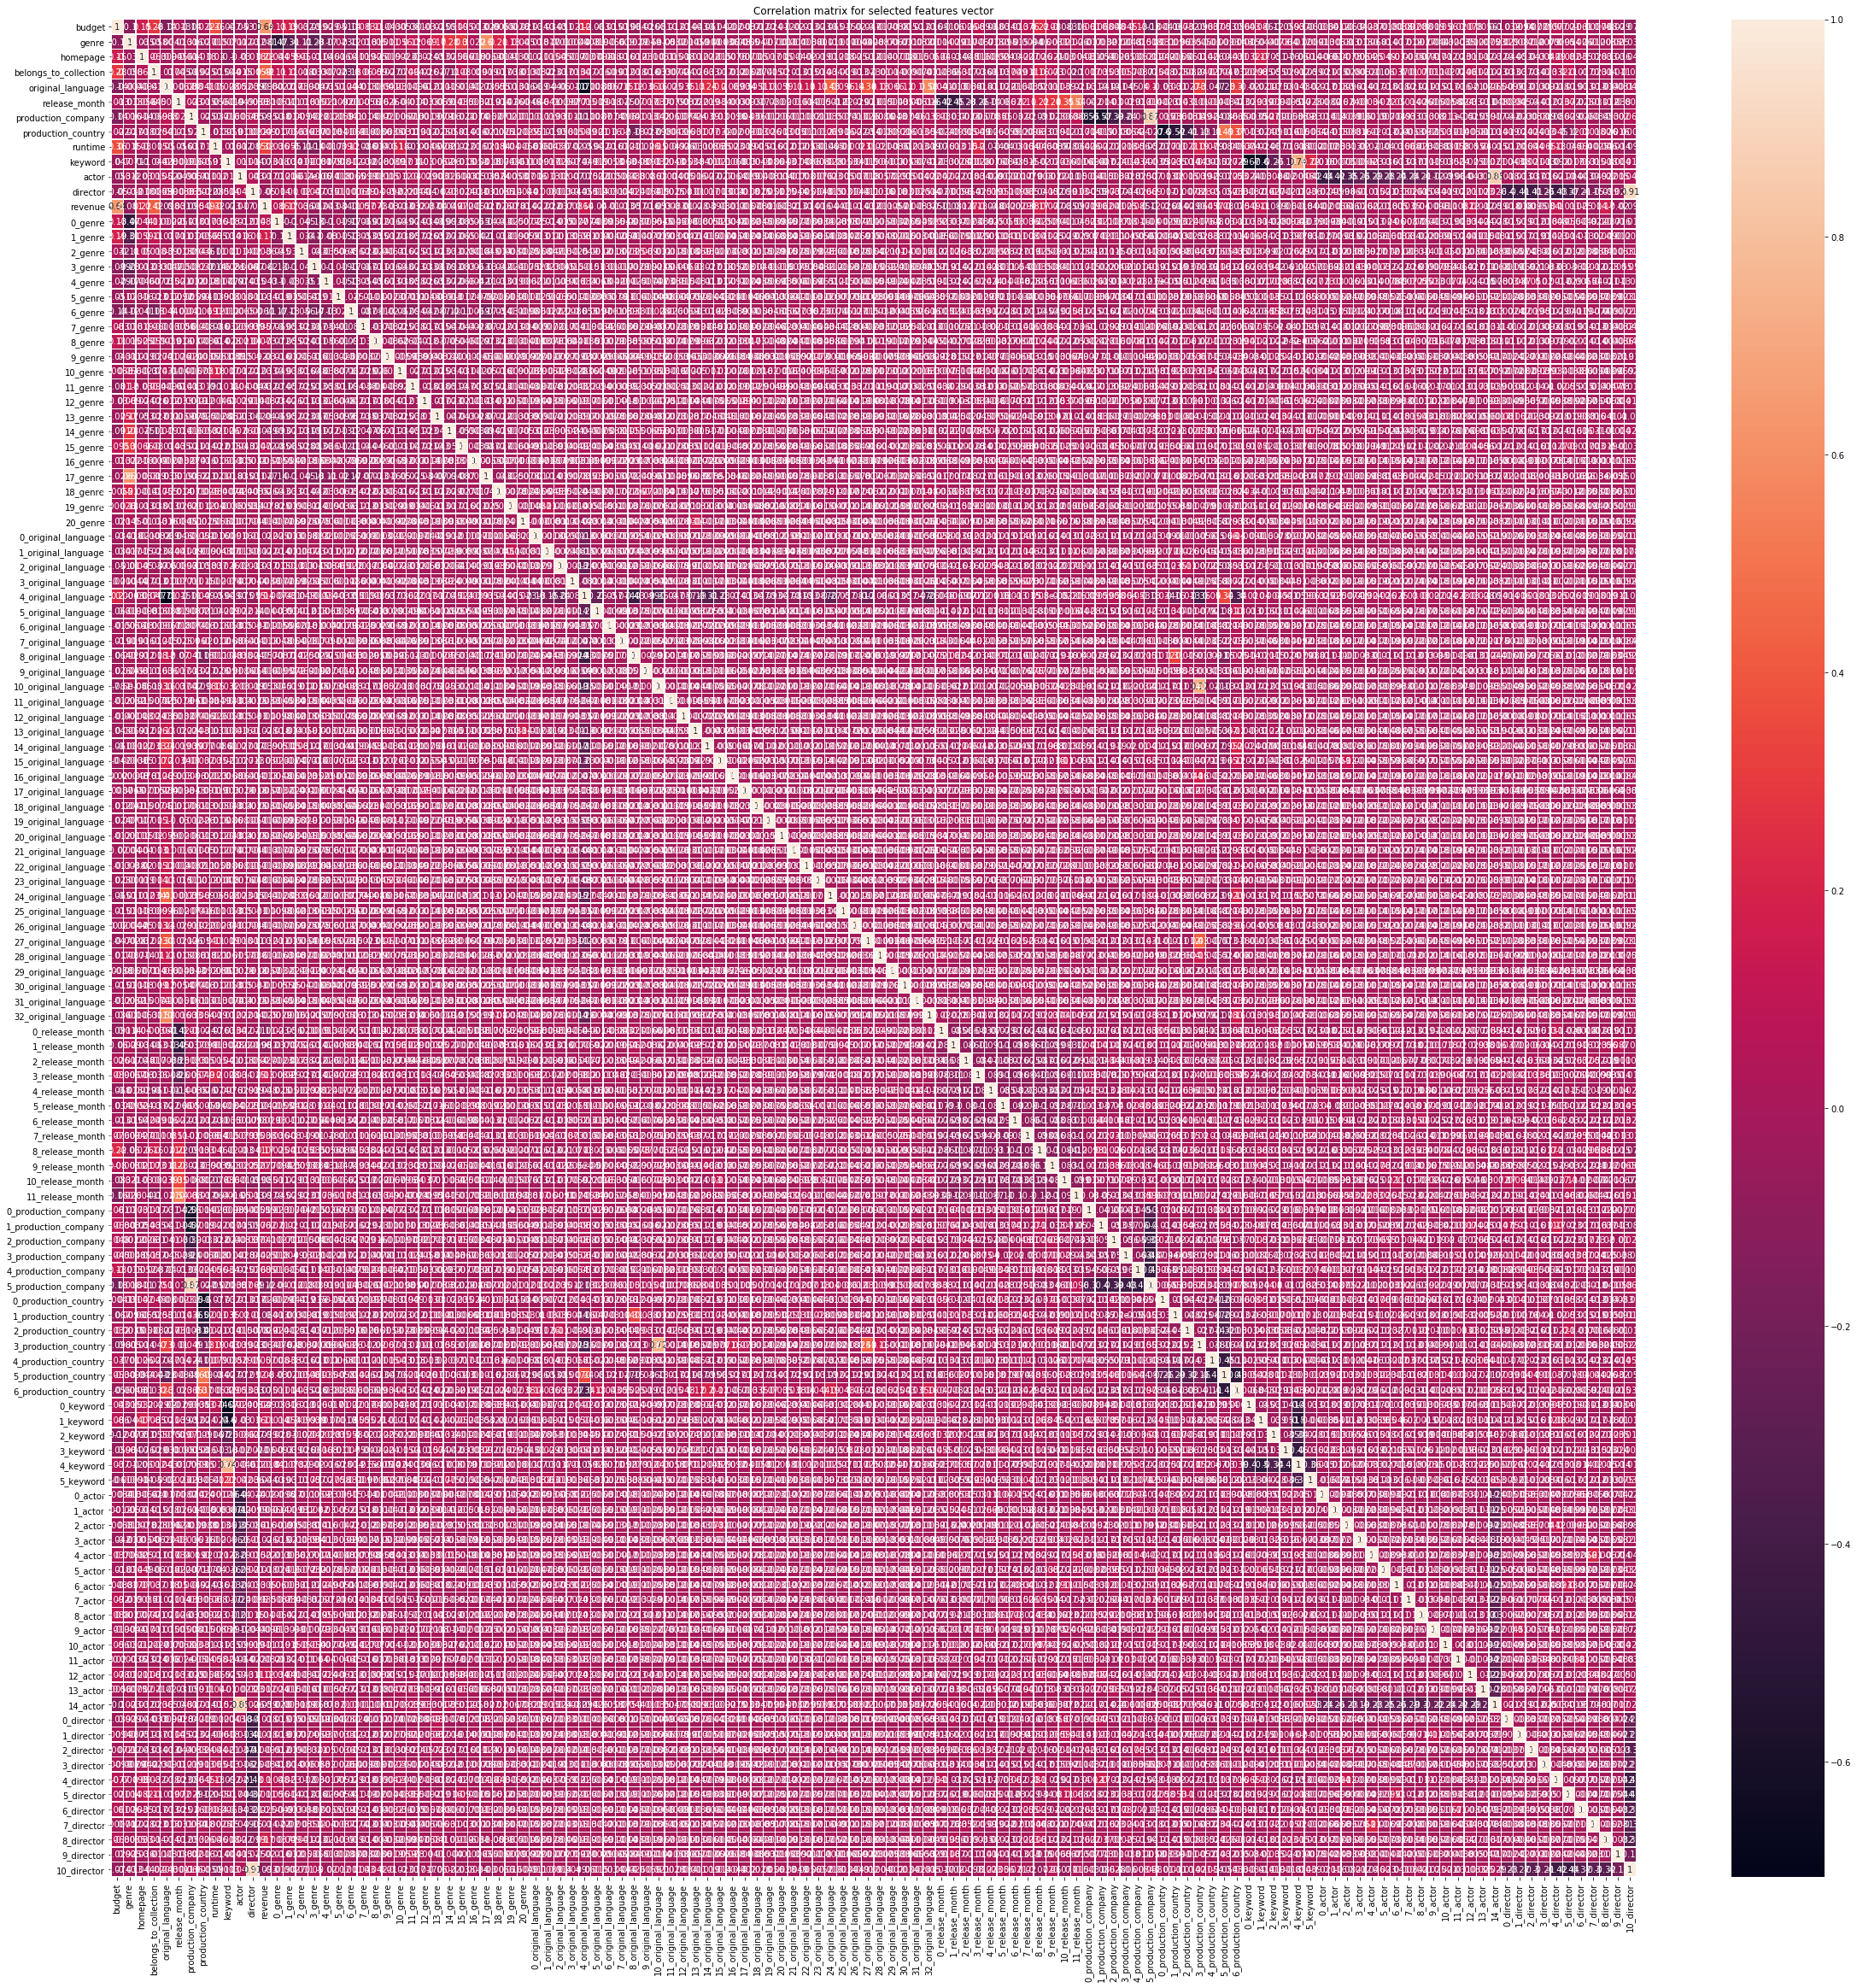

In [420]:
plt.subplots(figsize=(40, 40))
plt.title('Correlation matrix for selected features vector')
corr = engineering_dataset.corr()
sns.heatmap(corr, annot=True, xticklabels=engineering_dataset.columns,yticklabels=engineering_dataset.columns, linewidths=.5)